[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)]()

In [1]:
import sys
# !{sys.executable} git+https://github.com/huggingface/transformers -q
!{sys.executable} -m pip install transformers -q
!{sys.executable} -m pip install accelerate -q
!{sys.executable} -m pip install flash-attn --no-build-isolation -q
!{sys.executable} -m pip install datasets -q


In [2]:
!nvidia-smi

Wed Dec  3 20:20:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:A2:00.0 Off |                  Off |
| 30%   41C    P8             18W /  450W |    8939MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#Loading of the model

In [3]:
import torch
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor
from peft import PeftModel

base_model_name = "Qwen/Qwen3-VL-2B-Instruct"     # оригинальная модель
adapter_name = "leinms/Qwen3-VL-2B-Instruct-trl-sft"  # ваша LoRA модель

# Загружаем базовую модель
model = Qwen3VLForConditionalGeneration.from_pretrained(
    base_model_name,
    dtype="auto",
    attn_implementation="flash_attention_2",
    device_map="cuda",
)

# Загружаем ваши LoRA веса поверх базовой модели
model = PeftModel.from_pretrained(model, adapter_name)

# Процессор общий с базовой моделью
processor = AutoProcessor.from_pretrained(base_model_name)

torch.cuda.is_available(), torch.cuda.get_device_name(0)

`torch_dtype` is deprecated! Use `dtype` instead!
You are attempting to use Flash Attention 2 without specifying a torch dtype. This might lead to unexpected behaviour


(True, 'NVIDIA GeForce RTX 4090')

#Loading of the dataset

In [4]:
from datasets import load_dataset

ds_dict = load_dataset("Mozilla/flickr30k-transformed-captions-gpt4o")
ds = ds_dict["test"]   # единственный сплит

test_ds = ds.filter(lambda example: example["split"] == "test")
train_ds = ds.filter(lambda example: example["split"] == "train")

README.md: 0.00B [00:00, ?B/s]

data/test-00000-of-00003.parquet:   0%|          | 0.00/405M [00:00<?, ?B/s]

data/test-00001-of-00003.parquet:   0%|          | 0.00/401M [00:00<?, ?B/s]

data/test-00002-of-00003.parquet:   0%|          | 0.00/412M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/31014 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31014 [00:00<?, ? examples/s]

Filter:   0%|          | 0/31014 [00:00<?, ? examples/s]

#Function for the model inference

In [8]:
def caption_with_qwen(example):
    test_example_image = example["image"]


    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": test_example_image,
                },
                {"type": "text", "text": "Describe this image."},
            ],
        }
    ]    

    inputs = processor.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_dict=True,
        return_tensors="pt",
    ).to(model.device)

    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=64,
            do_sample=False,
            # temperature=0.0,
        )

    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )[0]

    return {"baseline_answ": output_text.strip()}


#Check function

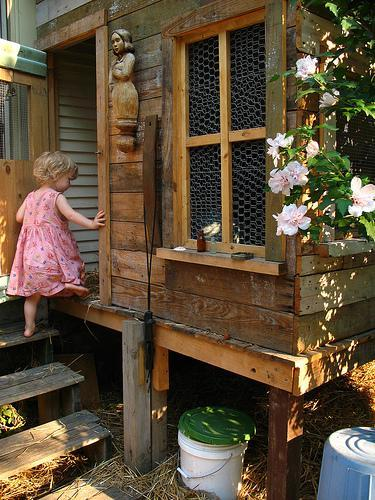

In [11]:
test_example = ds[2]
test_example['image']

In [12]:
model_answer = caption_with_qwen(test_example)
model_answer['baseline_answ']

'A child climbing steps near a wooden structure with flowers.'

#Launch inference for the test dataset

In [13]:
from tqdm.auto import tqdm

# прогресс-бар для map
tqdm.pandas()

ds_with_baseline = test_ds.map(
    caption_with_qwen,
    desc="Running Qwen3-VL on test split",
)
ds_with_baseline


Running Qwen3-VL on test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'alt_text', 'sentids', 'split', 'img_id', 'filename', 'original_alt_text', 'objects', 'baseline_answ'],
    num_rows: 1000
})

In [14]:
from huggingface_hub import notebook_login
notebook_login()

In [16]:
ds_with_baseline.push_to_hub("leinms/flickr30k-Qwen3-VL-2B-Instruct-trl-sft")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  42%|####1     | 16.8MB / 40.0MB            

CommitInfo(commit_url='https://huggingface.co/datasets/leinms/flickr30k-Qwen3-VL-2B-Instruct-trl-sft/commit/7799389859c7a552441146b69a604e1e9b264a36', commit_message='Upload dataset', commit_description='', oid='7799389859c7a552441146b69a604e1e9b264a36', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/leinms/flickr30k-Qwen3-VL-2B-Instruct-trl-sft', endpoint='https://huggingface.co', repo_type='dataset', repo_id='leinms/flickr30k-Qwen3-VL-2B-Instruct-trl-sft'), pr_revision=None, pr_num=None)